# Notebook for Testing the plotting of CLV Data for the PO Model

### Imports

In [766]:
######################
##	Library Imports
######################
%matplotlib inline
import matplotlib as mpl
# mpl.use('TkAgg') # Use this backend for displaying plots in window
# mpl.use('Agg') # Use this backend for writing plots to file

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize']    = [16, 9]
# mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['text.usetex']       = True
mpl.rcParams['font.family']       = 'serif'
mpl.rcParams['font.size']         = 22
mpl.rcParams['font.serif']        = 'Computer Modern Roman'
mpl.rcParams['lines.linewidth']   = 1.25
mpl.rcParams['lines.markersize']  = 6
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import h5py
import sys
import os
import time as TIME
import multiprocessing as mprocs
from threading import Thread
from subprocess import Popen, PIPE
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import zip_longest
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import cm 
import numpy as np
from scipy.linalg import subspace_angles
np.set_printoptions(threshold=sys.maxsize)
from numba import jit, prange

mpl.get_backend()

'module://ipykernel.pylab.backend_inline'

### Open Data File

In [767]:
## System Parameters
N       = 256
k0      = 1
alpha   = 0.25
beta    = 0.0 
iters   = 400000
m_end   = 8000
m_iters = 50
trans   = 1000
u0      = "RANDOM"


In [768]:
## Read open data file
results_dir = "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]".format(N, k0, alpha, beta, u0)
filename    = "/CLVData_ITERS[{},{},{}]_TRANS[{}]".format(iters, m_end, m_iters, trans)

input_dir  = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS"
output_dir = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS/" + results_dir

In [769]:
HDFfileData = h5py.File(input_dir + results_dir + filename + '.h5', 'r')
print("\n\nData File: {}.h5\n".format(results_dir + filename))



Data File: /RESULTS_N[256]_k0[1]_ALPHA[0.250]_BETA[0.000]_u0[RANDOM]/CLVData_ITERS[400000,8000,50]_TRANS[1000].h5



### Read In Data

In [770]:
## Read in datasets
phases = HDFfileData['Phases'][:, :]
time   = HDFfileData['Time'][:]
amps   = HDFfileData['Amps'][:]
lce    = HDFfileData['LCE'][:, :]
CLVs   = HDFfileData['CLVs']

## System Parameters
num_tsteps = len(time);
num_clv_steps = CLVs.shape[0]
num_osc    = phases.shape[1];
kmin       = k0 + 1;
kmax       = num_osc - 1;
dof        = num_osc - kmin

In [771]:
## Reshape the CLV data
clv_dims = CLVs.attrs['CLV_Dims']
CLV      = np.reshape(CLVs, (CLVs.shape[0], dof, dof))

### Compute Angles Between Vectors

In [772]:
@jit(nopython = True)
def compute_angles_t(clv, num_tsteps, dof):
    angles = np.zeros((num_tsteps, dof, dof))
    
    for t in range(num_tsteps):
        for i in range(dof):
            for j in range(i):
                mat = np.transpose(CLV[t, :, :])
                angles[t, i, j] = np.arccos(np.absolute(np.dot(mat[i, :], mat[j, :])))
    
    return angles

In [773]:
@jit(nopython = True)
def compute_angles(clv, num_tsteps, dof):
    angles = np.zeros((num_tsteps, dof, dof))
    
    for t in range(num_tsteps):
        for i in range(dof):
            for j in range(i):
                mat = CLV[t, :, :]
                angles[t, i, j] = np.arccos(np.absolute(np.dot(mat[:, i], mat[:, j])))
    
    return angles

In [774]:
# %%timeit 
angles = compute_angles_t(CLV, num_clv_steps, dof)
# print(angles.shape)

<ipython-input-772-115130022f69>:9: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (readonly array(float64, 1d, A), readonly array(float64, 1d, A))
  angles[t, i, j] = np.arccos(np.absolute(np.dot(mat[i, :], mat[j, :])))


In [775]:
# %%timeit
angles = compute_angles(CLV, num_clv_steps, dof)
angles.shape

<ipython-input-773-eb129656c53b>:9: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (readonly array(float64, 1d, A), readonly array(float64, 1d, A))
  angles[t, i, j] = np.arccos(np.absolute(np.dot(mat[:, i], mat[:, j])))


(796, 127, 127)

### Compute the Squared Time Averaged Lyapunov Vector Components

In [776]:
@jit(nopython = True)
def compute_zdata(clv, num_tsteps, dof):
    
    z_data   = np.zeros((dof, dof))
    
    for t in range(num_tsteps):
        z_data += np.square(clv[t, :, :])
    
    z_data = z_data / num_tsteps
    
    return z_data

In [777]:
zdata = compute_zdata(CLV, num_clv_steps, dof)

In [778]:
@jit(nopython = True)
def compute_energy(clv, num_tsteps, dof):
    
    even = np.zeros((num_tsteps))
    odd  = np.zeros((num_tsteps))
    
    for t in range(num_tsteps):
        even[t] = np.linalg.norm(clv[t, ::2, :])
        odd[t]  = np.linalg.norm(clv[t, 1::2, :])
            
    return even, odd

In [779]:
even_data, odd_data = compute_energy(CLV, num_clv_steps, dof)

## Plot the Data

### Squared Time Averaged Lyapunov Vector Components

In [780]:
# find the zero Lyap Exp
minval  = np.amin(np.absolute(lce[-1, :]))
minindx = np.where(np.absolute(lce[-1, :]) == minval)
minindx_el,  = minindx
print(minindx_el)
zeroindx = minindx_el[0]

# Extract positive and neg Exponents
lce_pos = lce[-1, :minindx_el[0]]
lce_neg = lce[-1, minindx_el[0] + 1:]

# Extract positive and negative vectors
CLV_expand   = CLV[0, :, :minindx_el[0]]
CLV_zero     = CLV[0, :, :minindx_el[0]]
CLV_contract = CLV[0, :, minindx_el[0] + 1:]

[63]


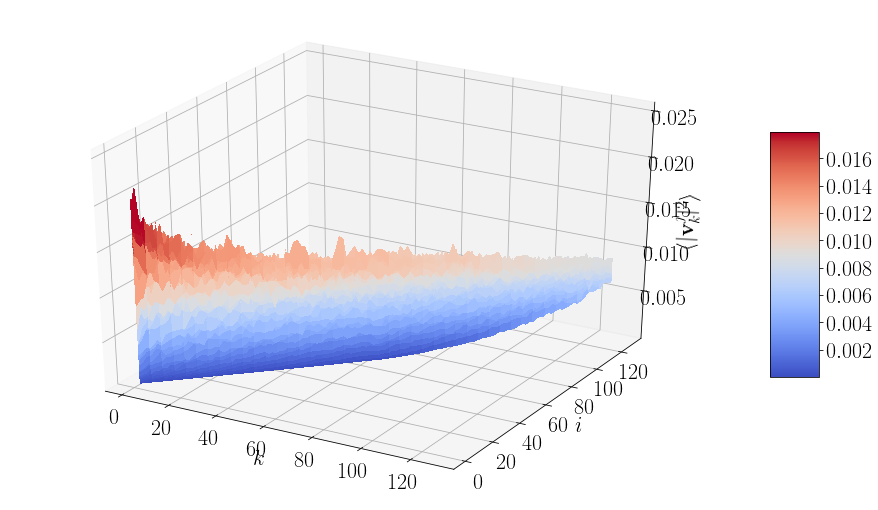

In [781]:
fig = plt.figure(figsize = (16, 9))
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(range(kmin, num_osc), range(1, dof + 1), np.flipud(zdata), cmap = cm.coolwarm, linewidth = 0, antialiased = False) 
ax.set_xlabel(r"$k$")
ax.set_ylabel(r"$i$")
ax.set_zlabel(r"$\langle |\mathbf{v}_k^j |^2\rangle$")
fig.colorbar(surf, shrink = 0.5, aspect = 5)
plt.show()

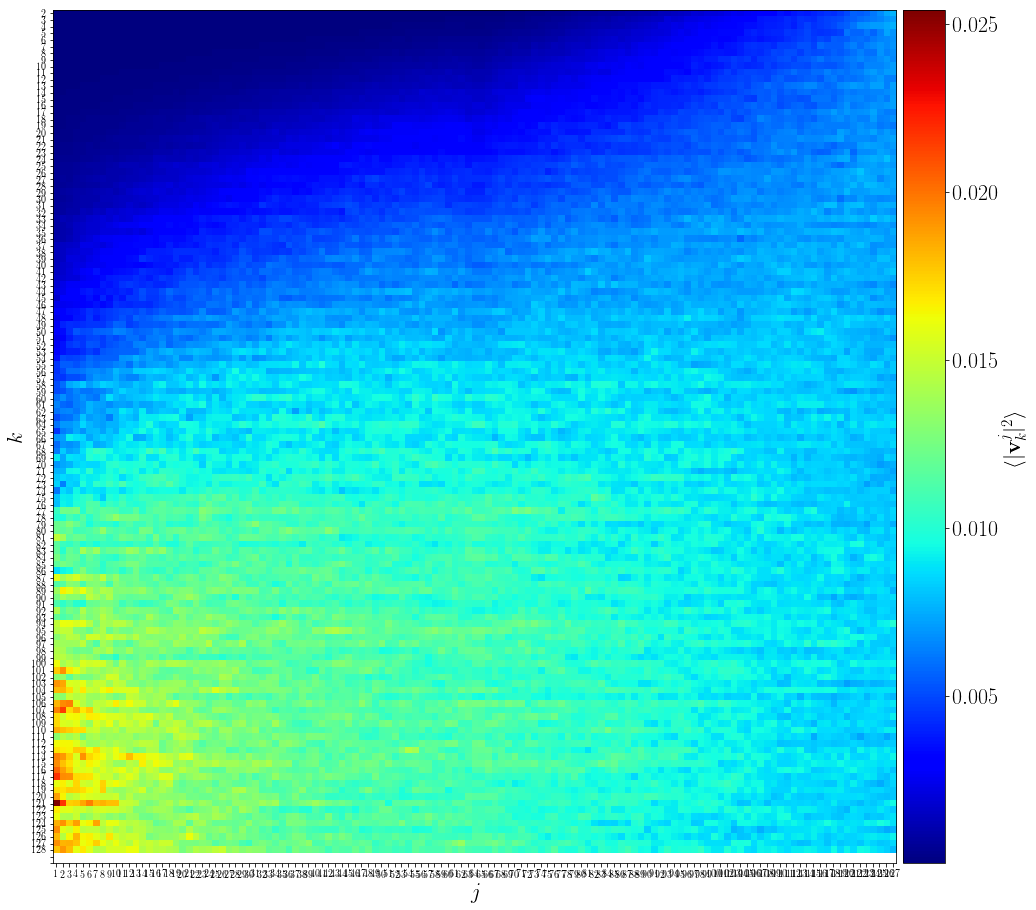

In [782]:
fig = plt.figure(figsize = (16, 16), tight_layout = False)
gs  = GridSpec(1, 1, wspace = 0.35)

ax2 = fig.add_subplot(gs[0, 0])
im  = ax2.imshow(zdata, cmap = cm.jet)#extent = [1, dof, kmin, num_osc]
ax2.set_xlabel(r"$j$")
ax2.set_ylabel(r"$k$")
ax2.set_yticks(np.arange(0, num_osc))
ax2.set_yticklabels(np.arange(kmin, num_osc), fontsize = 10)
ax2.set_xticks(np.arange(0, dof))
ax2.set_xticklabels(np.arange(1, dof + 1), fontsize = 10)
div2  = make_axes_locatable(ax2)
cax2  = div2.append_axes('right', size = '5%', pad = 0.1)
cbar = plt.colorbar(im, cax = cax2, orientation = 'vertical')
cbar.set_label(r"$\langle |\mathbf{v}_k^j |^2\rangle$")
# ax21  = div2.append_axes('left', size = '5%', pad = 0.8, sharey = ax2)
# ax22  = div2.append_axes('bottom', size = '8%', pad = 0.8, sharex = ax2)
# for i in range(1, dof + 1):
#     if i == zeroindx:
# #         ax21.plot(0.5, i + 0.5, markerfacecolor = 'black', markeredgecolor = 'black', marker = 'o')
#         ax22.plot(i + 0.5, 0.5, markerfacecolor = 'black', markeredgecolor = 'black', marker = 'o', label = r"$\lambda_i = 0$", c = "w")
#     elif i < zeroindx: 
# #         ax21.plot(0.5, i + 0.5, markerfacecolor = 'blue', markeredgecolor = 'blue', marker = 'o', alpha = (dof - i)/dof)
#         ax22.plot(i + 0.5, 0.5, markerfacecolor = 'blue', markeredgecolor = 'blue', marker = 'o', alpha = (dof - i)/dof, label = r"$\lambda_i > 0$", c = "w")
#     elif i > zeroindx: 
# #         ax21.plot(0.5, i + 0.5, markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', alpha = (i)/dof)
#         ax22.plot(i + 0.5, 0.5, markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', alpha = (i)/dof, label = r"$\lambda_i < 0$", c = "w")
# # ax21.set_ylim(1, dof)
# ax22.set_xlim(1, dof)
# # ax21.axis("off")
# ax22.axis("off")


# ax3 = fig.add_subplot(gs[0, 1])
# ax3.plot(even_data)
# ax3.plot(odd_data)
# ax3.set_xlabel(r"$t$")
# ax3.set_ylabel(r"$\| \mathbf{v}_k\|$")
# ax3.legend([r"$k = $ even", r"$k = $ odd"])


# plt.savefig("/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Testing_Functions/CLV" + "/TimeAverage.pdf")  
# plt.close()

plt.show()


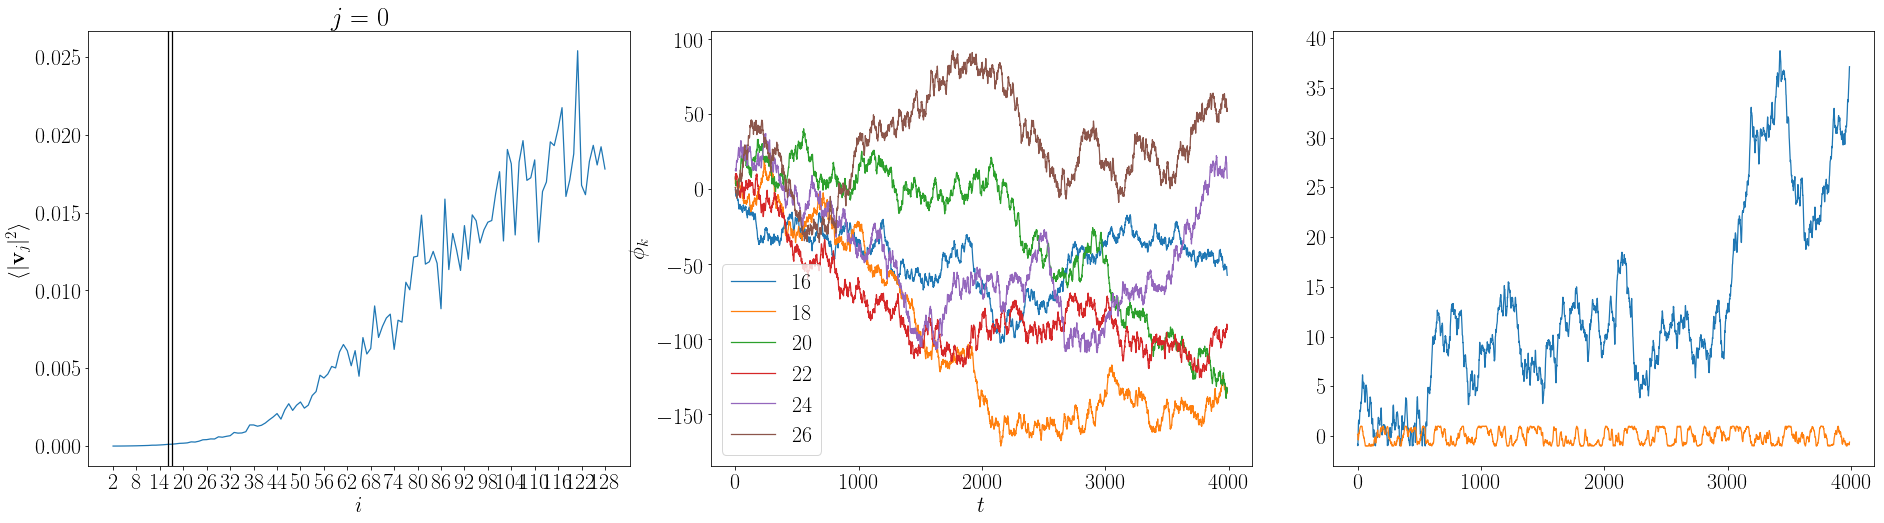

[[0.         0.         4.16664834 3.00654244 3.36077242]
 [0.         0.         4.27265171 2.88690773 3.7200699 ]
 [0.         0.         4.32614603 2.81148938 3.85834138]
 [0.         0.         4.37501315 2.86142676 3.93555325]
 [0.         0.         4.41661957 2.74491059 4.0437476 ]
 [0.         0.         4.39081042 2.66238208 4.00699006]
 [0.         0.         4.41483084 2.52478956 4.06099458]
 [0.         0.         4.40486227 2.48860107 4.01260777]
 [0.         0.         4.34232753 2.41963898 3.8011029 ]
 [0.         0.         4.22809439 2.31970432 3.79557209]]
(3990, 129)
1000


In [783]:
# print(lce[-1, :])
# print(lce[-1, zeroindx])
# print(zeroindx)
# print(CLV[100, :10, :3])

phi_kmax = 25
v_max = 10
j = 0
fig = plt.figure(figsize = (32, 8), tight_layout = False)
gs  = GridSpec(1, 3, wspace = 0.15)


ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(zdata[:, j])
ax1.set_xticks(np.arange(0, dof, 6))
ax1.set_xticklabels(np.arange(kmin, num_osc, 6))
ax1.axvline(x = 14, color = 'black')
ax1.axvline(x = 15, color = 'black')
ax1.set_xlabel(r"$i$")
ax1.set_ylabel(r"$\langle |\mathbf{v}_j |^2\rangle$")
ax1.set_title(r"$j = {}$".format(j))
# ax1.set_yscale("log")

ax2 = fig.add_subplot(gs[0, 1])
# ax2.plot(np.mod(phases[:, kmin:28], 2*np.pi))
ax2.plot(phases[:, 16:26 + 1: 2])
ax2.set_xlabel(r"$t$")
ax2.set_ylabel(r"$\phi_k$")
# ax2.set_title(r"$k \in$ $[k_0 + 1, {}]$".format(phi_kmax - 1))
ax2.legend(np.arange(16, 26 + 1, 2))

ax3 = fig.add_subplot(gs[0, 2])
ax3.plot(np.absolute(phases[:, 3] - phases[:, 5] + 1) - 1 )
# ax3.plot(phases[:, 3] - phases[:, 5])
ax3.plot(np.sin(phases[:, 3]))
# ax3.plot(np.sin(phases[:, 6]))
# ax3.plot(phases[:, 5])
# ax3.plot(phases[:, 3])
# ax3.set_ylabel(r"$\phi_k - \phi_j$")
# ax3.plot(CLV[-100:, 0:v_max - kmin, zeroindx])
# ax3.set_xlabel(r"$t$")
# ax3.set_ylabel(r"$v_i$")
# ax3.set_title(r"$[0, {}]$ Components of Zero vector".format(v_max - kmin - 1))

plt.show()

print(phases[10:20, 0:5])
print(phases.shape)
print(trans)

### Angles Plots

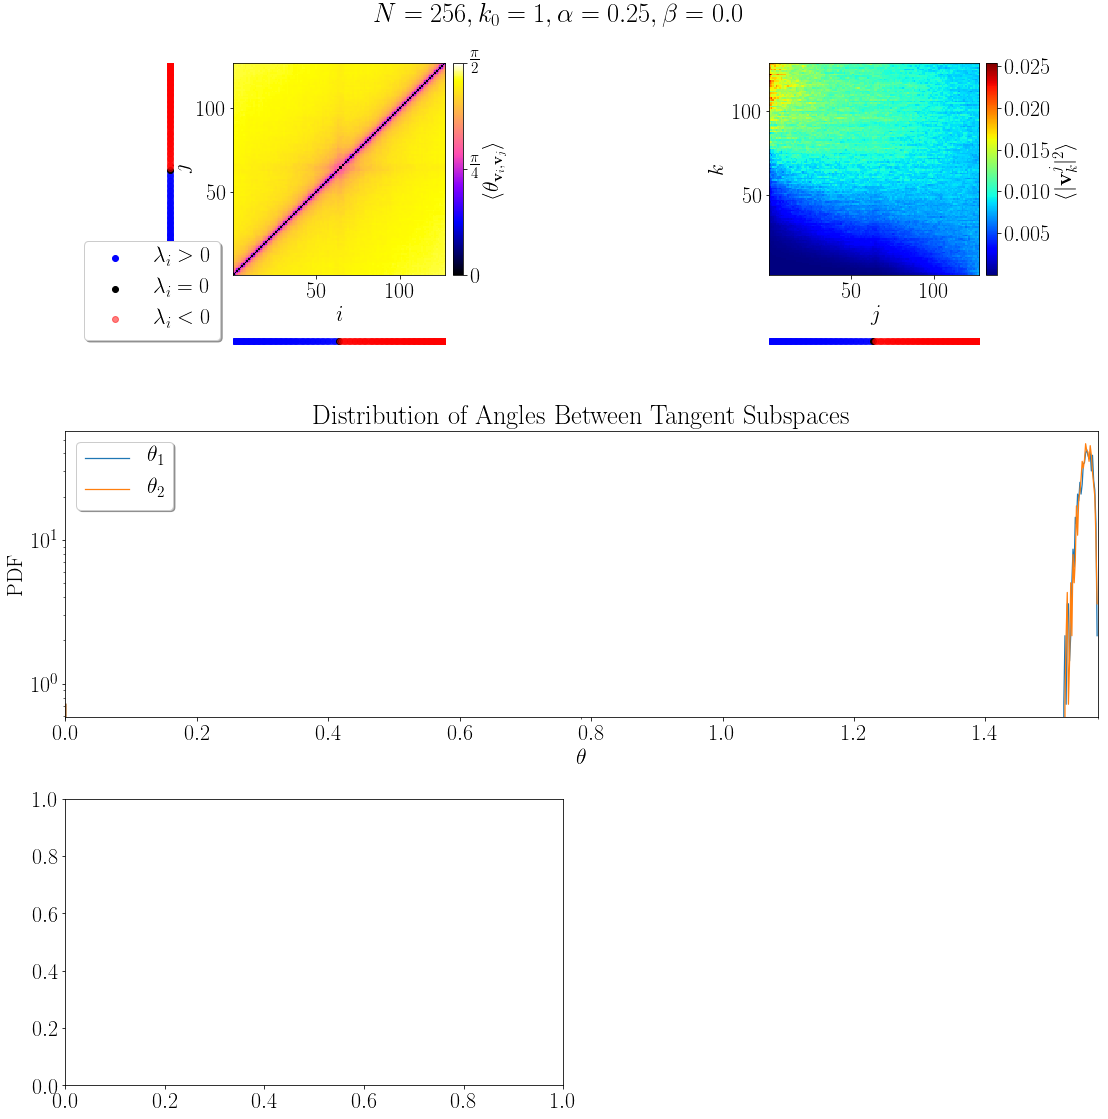

In [784]:
fig = plt.figure(figsize = (16, 16))
gs  = GridSpec(3, 2)

t = 1000

cmap_new = cm.jet
# cmap_new.set_bad(color = 'black')

# Angles
ax1 = fig.add_subplot(gs[0, 0])
data = np.mean(angles[:, :, :], axis = 0)
im1  = ax1.imshow(np.flipud(data + data.T - np.diag(np.diag(data))), cmap = cm.gnuplot2, extent = [1, dof, 1, dof], vmin = 0.0, vmax = np.pi/2.0)
ax1.set_xlabel(r"$i$")
ax1.set_ylabel(r"$j$")
div1  = make_axes_locatable(ax1)
cax1  = div1.append_axes('right', size = '5%', pad = 0.1)
cbar1 = plt.colorbar(im1, cax = cax1, orientation = 'vertical')
cbar1.set_ticks([ 0.0, np.pi/4.0, np.pi/2.0])
cbar1.set_ticklabels([r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"])
cbar1.set_label(r"$\langle\theta_{\mathbf{v}_i, \mathbf{v}_j}\rangle$")
ax11  = div1.append_axes('left', size = '5%', pad = 0.8, sharey = ax1)
ax12  = div1.append_axes('bottom', size = '8%', pad = 0.8, sharex = ax1)
for i in range(1, dof + 1):
    if i == zeroindx:
        ax11.plot(0.5, i + 0.5, markerfacecolor = 'black', markeredgecolor = 'black', marker = 'o')
        ax12.plot(i + 0.5, 0.5, markerfacecolor = 'black', markeredgecolor = 'black', marker = 'o', label = r"$\lambda_i = 0$", c = "w")
    elif i < zeroindx: 
        ax11.plot(0.5, i + 0.5, markerfacecolor = 'blue', markeredgecolor = 'blue', marker = 'o', alpha = (dof - i)/dof)
        ax12.plot(i + 0.5, 0.5, markerfacecolor = 'blue', markeredgecolor = 'blue', marker = 'o', alpha = (dof - i)/dof, label = r"$\lambda_i > 0$", c = "w")
    elif i > zeroindx: 
        ax11.plot(0.5, i + 0.5, markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', alpha = (i)/dof)
        ax12.plot(i + 0.5, 0.5, markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', alpha = (i)/dof, label = r"$\lambda_i < 0$", c = "w")
ax11.set_ylim(1, dof)
ax12.set_xlim(1, dof)
ax11.axis("off")
ax12.axis("off")
ax12.legend(loc = "lower right", bbox_to_anchor = (-0.01, -0.1), fancybox = True, framealpha = 1, shadow = True)

## Time Averaged
ax2 = fig.add_subplot(gs[0, 1])
im  = ax2.imshow(np.flipud(zdata), cmap = cm.jet, extent = [1, dof, kmin, num_osc])
ax2.set_xlabel(r"$j$")
ax2.set_ylabel(r"$k$")
div2 = make_axes_locatable(ax2)
cax2 = div2.append_axes('right', size = '5%', pad = 0.1)
cbar = plt.colorbar(im, cax = cax2, orientation = 'vertical')
cbar.set_label(r"$\langle |\mathbf{v}_k^j |^2\rangle$")
ax21  = div2.append_axes('left', size = '5%', pad = 0.8, sharey = ax2)
ax22  = div2.append_axes('bottom', size = '8%', pad = 0.8, sharex = ax2)
for i in range(1, dof + 1):
    if i == zeroindx:
        ax22.plot(i + 0.5, 0.5, markerfacecolor = 'black', markeredgecolor = 'black', marker = 'o', label = r"$\lambda_i = 0$", c = "w")
    elif i < zeroindx: 
        ax22.plot(i + 0.5, 0.5, markerfacecolor = 'blue', markeredgecolor = 'blue', marker = 'o', alpha = (dof - i)/dof, label = r"$\lambda_i > 0$", c = "w")
    elif i > zeroindx: 
        ax22.plot(i + 0.5, 0.5, markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', alpha = (i)/dof, label = r"$\lambda_i < 0$", c = "w")
ax22.set_xlim(1, dof)
ax21.axis("off")
ax22.axis("off")
plt.suptitle(r"$N = {}, k_0 = {}, \alpha = {}, \beta = {}$".format(N, k0, alpha, beta))


ax3 = fig.add_subplot(gs[1, 0:])
hist, bins  = np.histogram(theta1, range = (0.0, np.pi / 2.0), bins = 900, density = True);
bin_centers = (bins[1:] + bins[:-1]) * 0.5
plt.plot(bin_centers, hist)
hist, bins  = np.histogram(theta2, range = (0.0, np.pi / 2.0), bins = 900, density = True);
bin_centers = (bins[1:] + bins[:-1]) * 0.5
ax3.plot(bin_centers, hist)
ax3.set_xlim(0.0, np.pi/2.0)
ax3.set_xlabel(r"$\theta$")
ax3.set_xticks([0.0, np.pi/4.0, np.pi/2.0],[r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"]);
ax3.set_ylabel(r"PDF")
ax3.set_yscale("log")
ax3.legend([r"$\theta_1$", r"$\theta_2$"], fancybox = True, framealpha = 1, shadow = True)
ax3.set_title(r"Distribution of Angles Between Tangent Subspaces")


ax4 = fig.add_subplot(gs[2, 0])


# # plt.savefig("/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Testing_Functions/CLV" + "/Angles1.pdf")  

plt.tight_layout(rect = (0, 0, 1, 0.96))
plt.show()

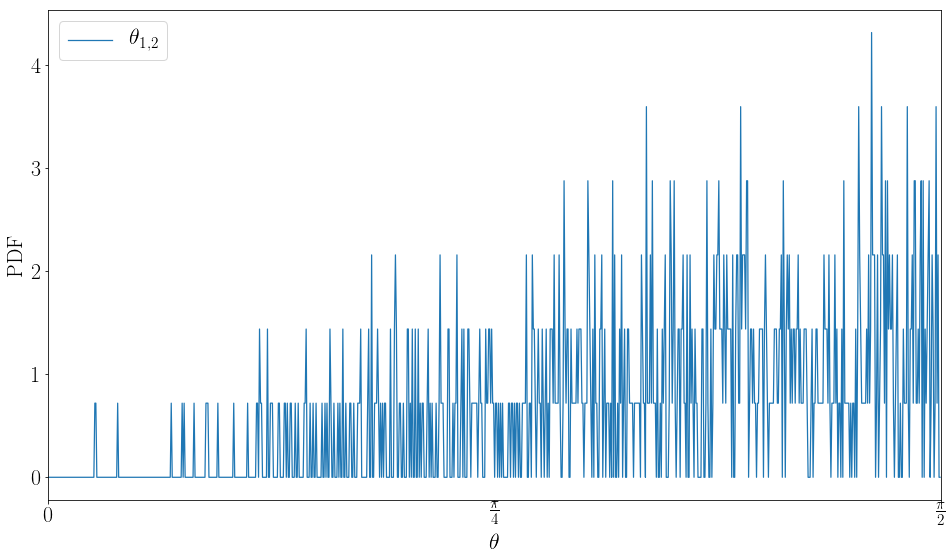

In [785]:
plt.figure()
hist, bins  = np.histogram(angles[:, 6, 3], range = (0.0, np.pi / 2.0), bins = 900, density = True);
bin_centers = (bins[1:] + bins[:-1]) * 0.5
plt.plot(bin_centers, hist)
plt.xlim(0.0, np.pi/2.0)
plt.xlabel(r"$\theta$")
plt.xticks([0.0, np.pi/4.0, np.pi/2.0],[r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"]);
plt.legend([r"$\theta_{1, 2}$"])
plt.ylabel(r"PDF")
plt.show()

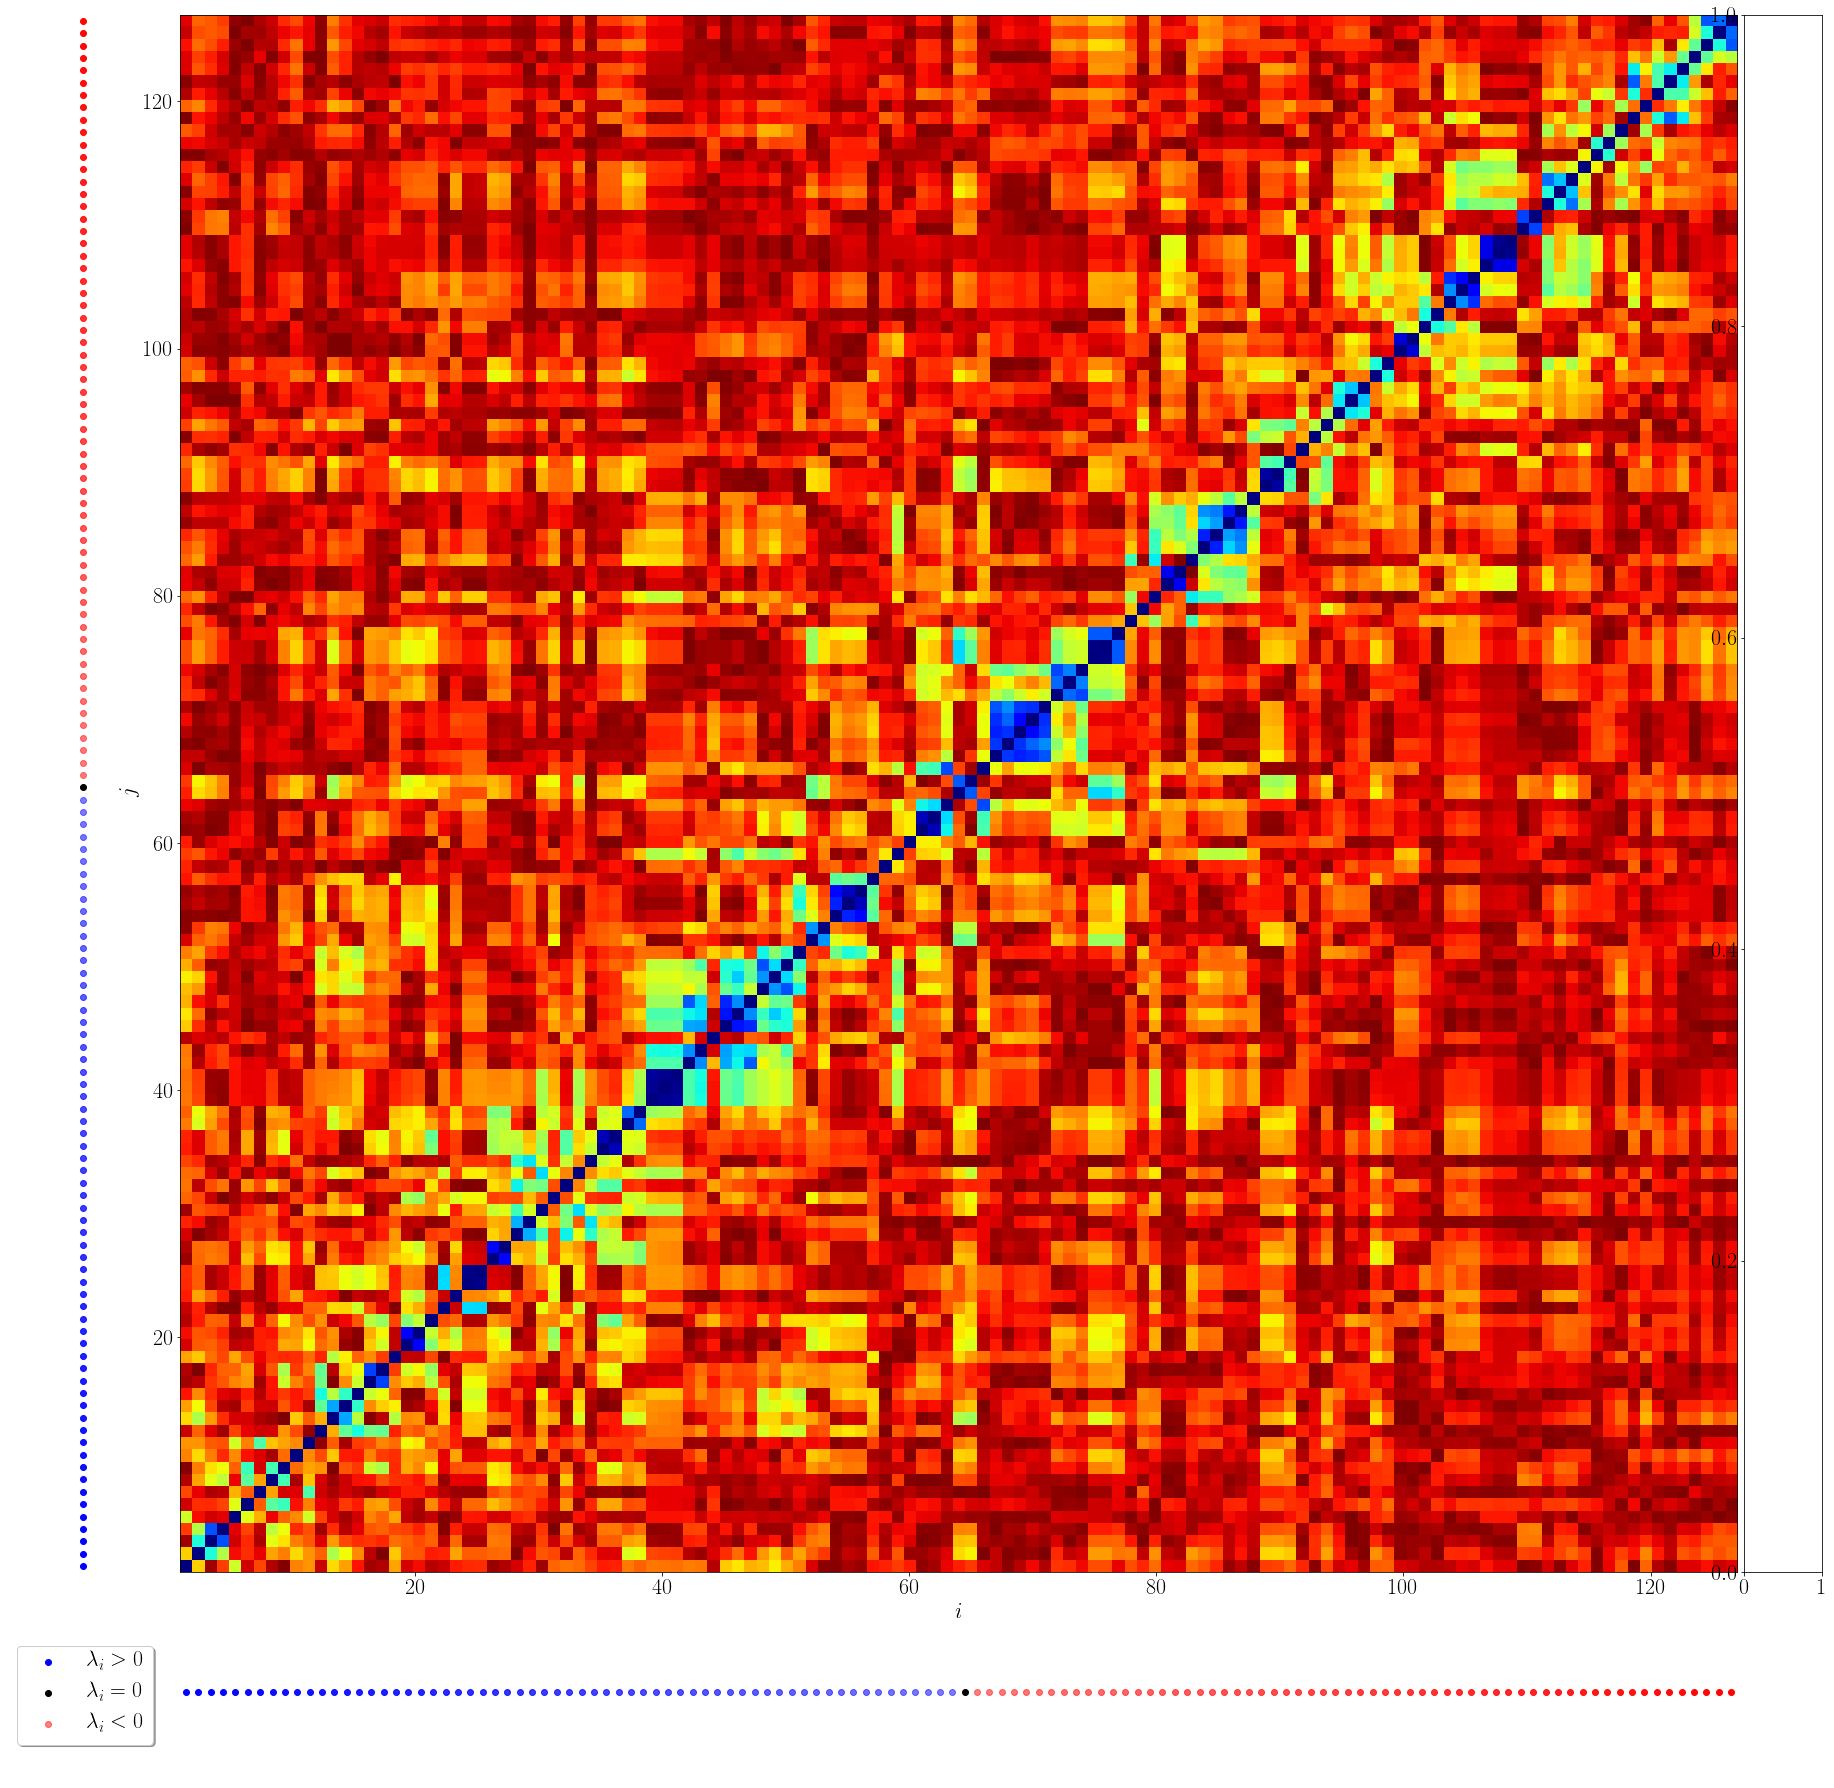

127
129
63


In [795]:
fig = plt.figure(figsize = (32, 32))
gs  = GridSpec(1, 1)

ax1 = fig.add_subplot(gs[0, 0])
im  = ax1.imshow(np.flipud(angles[10, :, :] + angles[10, :, :].T - np.diag(np.diag(angles[10, :, :]))), cmap = cmap_new, extent = [1, dof, 1, dof], vmin = 0.0, vmax = np.pi/2.0)
ax1.set_xlabel(r"$i$")
ax1.set_ylabel(r"$j$")
div1  = make_axes_locatable(ax1)
cax1  = div1.append_axes('right', size = '5%', pad = 0.1)
ax11  = div1.append_axes('left', size = '5%', pad = 0.8, sharey = ax1)
ax12  = div1.append_axes('bottom', size = '8%', pad = 0.8, sharex = ax1)
for i in range(0, dof - 1):
    if i == zeroindx:
        ax11.plot(0.5, i + 1.5, markerfacecolor = 'black', markeredgecolor = 'black', marker = 'o')
        ax12.plot(i + 1.5, 0.5, markerfacecolor = 'black', markeredgecolor = 'black', marker = 'o', label = r"$\lambda_i = 0$", c = "w")
    elif i < zeroindx: 
        ax11.plot(0.5, i + 1.5, markerfacecolor = 'blue', markeredgecolor = 'blue', marker = 'o', alpha = (dof - i)/dof)
        ax12.plot(i + 1.5, 0.5, markerfacecolor = 'blue', markeredgecolor = 'blue', marker = 'o', alpha = (dof - i)/dof, label = r"$\lambda_i > 0$", c = "w")
    elif i > zeroindx: 
        ax11.plot(0.5, i + 1.5, markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', alpha = (i)/dof)
        ax12.plot(i + 1.5, 0.5, markerfacecolor = 'red', markeredgecolor = 'red', marker = 'o', alpha = (i)/dof, label = r"$\lambda_i < 0$", c = "w")
ax11.set_ylim(1, dof)
ax12.set_xlim(1, dof)
# ax11.set_yticks(np.arange(0, dof))
# ax11.set_yticklabels(np.arange(1, dof + 1) + 1, fontsize = 10)
ax11.axis("off")
ax12.axis("off")
ax12.legend(loc = "lower right", bbox_to_anchor = (-0.01, -0.01), fancybox = True, framealpha = 1, shadow = True)

plt.draw()
plt.show()

print(dof)
print(num_osc)
print(zeroindx)

In [792]:
def compute_angles_subspaces(A1, B1, num_clv_steps):
    
    angles1 = np.zeros((num_clv_steps))
    
    for t in range(0, num_clv_steps):
        angles1[t] = subspace_angles(A1[t, :, :], B1[t, :, :])[0]
        
    return angles1

In [793]:
# %%timeit
theta1 = compute_angles_subspaces(CLV[:, :, :zeroindx + 1], CLV[:, :, zeroindx + 1:], num_clv_steps)
if zeroindx > 0:
    theta2 = compute_angles_subspaces(CLV[:, :, :zeroindx], CLV[:, :, zeroindx:], num_clv_steps)

63
[ 2.39012590e+02  2.16576225e+02  2.01788275e+02  1.89700850e+02
  1.79598197e+02  1.71484064e+02  1.64272185e+02  1.57245409e+02
  1.51399709e+02  1.45259233e+02  1.40097582e+02  1.34978493e+02
  1.30580676e+02  1.25848882e+02  1.21578065e+02  1.17494307e+02
  1.13276167e+02  1.09776643e+02  1.05811627e+02  1.02336381e+02
  9.86793401e+01  9.50246638e+01  9.18654880e+01  8.86416310e+01
  8.57303295e+01  8.23719425e+01  7.94209831e+01  7.64776754e+01
  7.33910314e+01  7.05591464e+01  6.77306747e+01  6.52453874e+01
  6.27181829e+01  6.00110625e+01  5.73941747e+01  5.47355834e+01
  5.23255924e+01  4.99731933e+01  4.73652961e+01  4.52719956e+01
  4.29315445e+01  4.07534841e+01  3.83587556e+01  3.61117278e+01
  3.38053269e+01  3.16089061e+01  2.97743251e+01  2.78319661e+01
  2.56730705e+01  2.35219975e+01  2.17689004e+01  1.97348760e+01
  1.79909625e+01  1.59246682e+01  1.43151045e+01  1.22929616e+01
  1.06482380e+01  8.75509678e+00  7.29892816e+00  5.52326131e+00
  3.84617913e+00  2.59

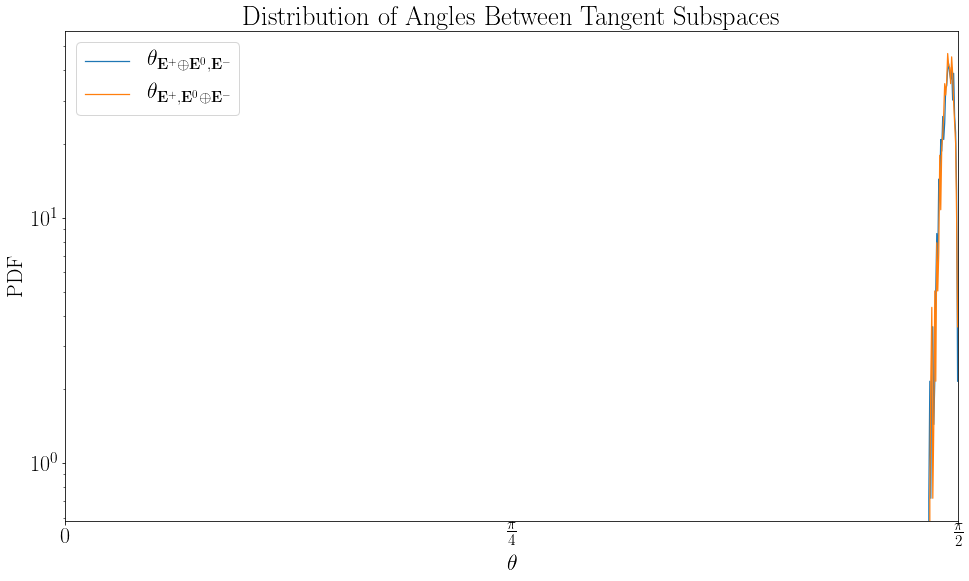

In [794]:
print(zeroindx)
print(lce[-1, :])
print(lce[-1, zeroindx])

print()
print(theta1)
print(theta2)


plt.figure()
hist, bins  = np.histogram(theta1, range = (0.0, np.pi / 2.0), bins = 900, density = True);
bin_centers = (bins[1:] + bins[:-1]) * 0.5
plt.plot(bin_centers, hist)
if zeroindx > 0:
    hist, bins  = np.histogram(theta2, range = (0.0, np.pi / 2.0), bins = 900, density = True);
    bin_centers = (bins[1:] + bins[:-1]) * 0.5
    plt.plot(bin_centers, hist)
plt.xlim(0.0, np.pi/2.0)
plt.xlabel(r"$\theta$")
plt.xticks([0.0, np.pi/4.0, np.pi/2.0],[r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$"]);
plt.legend([r"$\theta_{1, 2}$", r"$\theta_{1,3}$", r"$\theta_{2,3}$"])
plt.ylabel(r"PDF")
plt.yscale("log")
if zeroindx == 0:
    plt.legend([r"$\theta_{\mathbf{E}^0, \mathbf{E}^-}$"])
else:
    plt.legend([r"$\theta_{\mathbf{E}^+ \oplus \mathbf{E}^0, \mathbf{E}^-}$", r"$\theta_{\mathbf{E}^+, \mathbf{E}^0 \oplus \mathbf{E}^-}$"])
plt.title(r"Distribution of Angles Between Tangent Subspaces")
plt.show()